In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PIL.Image
import IPython.display
import io
import random
import time
import statistics as stats
from matplotlib import pyplot as plt

class CellularAutomata(tf.keras.Model):
    def __init__(self, img_size: int, channel_count: int, layers: [int], perception_kernel):
        super().__init__()
        
        self.img_size = img_size
        self.channel_count = channel_count
        self.conserve_mass = False
        self.noise = 0.0
        self.clamp_values = True
        self.randomfill_max = 1.0
        
        self.model = tf.keras.Sequential()
        
        for layer_size in layers:
            self.model.add(
                tf.keras.layers.Conv2D(filters=layer_size, kernel_size=1, 
                    activation=tf.nn.relu))
        
        self.model.add(
            tf.keras.layers.Conv2D(filters=channel_count, kernel_size=1, 
                activation=None, kernel_initializer=tf.zeros_initializer)
        )
        
        # Project the perception tensor so that it is 4D. This is used by the depthwise convolution
        # to create a dot product along the 3rd axis, but we don't need that so we index
        # it with None:
        perception_kernel = perception_kernel[:, :, None, :]
        perception_kernel = tf.repeat(perception_kernel, 
            repeats=self.channel_count, 
            axis=2)
        self.perception_kernel = perception_kernel

        # Compile the model by making a call to it.
        self(tf.zeros([1, 3, 3, channel_count]))
        
    @tf.function
    def perceive(self, x):
        return tf.nn.depthwise_conv2d(x, 
            filter=self.perception_kernel, 
            strides=[1, 1, 1, 1],
            padding="SAME")
    
    @tf.function
    def call(self, x):
        s = self.perceive(x)
        dx = self.model(s)
        
        # Add mass conservation to the model by subtracting the average of the dx values.
        if self.conserve_mass:
            dx -= tf.math.reduce_mean(dx)
        x += dx
        
        # Add random noise.
        x += (tf.cast(tf.random.uniform(tf.shape(x[:, :, :, :])), tf.float32) - 0.5) * 2.0 * self.noise
        
        # Keep random noise or changes in dx from causing out-of-range values.
        if self.clamp_values:
            x = tf.clip_by_value(x, 0.0, 1.0)
            
        return x

    def imagefilled(self, image_path):
        """ Fills the world with image data from the disk. """
        x = self.zerofilled()
        img = PIL.Image.open(image_path).convert("RGB")
        img = img.resize(size=(self.img_size, self.img_size))
        color_arr = np.float32(img) / 255.0
        x[:, :, :3] = color_arr
        return x

    def zerofilled(self):
        """ Fills the world with zeros. """
        return np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)

    def onefilled(self):
        """ Fills the world with ones. """
        return np.ones((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        
    def pointfilled(self):
        """ Fills the world with zeros except for a single point. """
        x = np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        x[self.img_size // 2, self.img_size // 2] = np.ones((self.channel_count,))
        return x
    
    def randomfilled(self):
        """ Fills the world with random numbers from 0 to the random fill maximum. """
        x = np.random.rand(self.img_size, self.img_size, self.channel_count).astype(np.float32) * self.randomfill_max
        return x
        
    def to_image(self, x, scale=1):
        # Slice off all the non-color (hidden channels):
        arr = x[..., :3]
        rgb_array = np.uint8(arr * 255.0)

        # Scale the first two dimensions of the image by the given scale.
        for dim in range(2):
            rgb_array = np.repeat(rgb_array, scale, dim)

        out = io.BytesIO()
        return PIL.Image.fromarray(rgb_array)
        PIL.Image.fromarray(rgb_array).save(out, 'png')
        return IPython.display.Image(data=out.getvalue())
    
    def display_gif(self, xs, scale=None):
        if scale is None:
            scale = 256 // self.img_size
            
        out = io.BytesIO()
        imgs = [self.to_image(x, scale) for x in xs]
        durs = [100 for img in imgs]
        durs[0] = 1000
        durs[-1] = 1000
        imgs[0].save(out, 'gif', save_all=True, append_images=imgs[1:], loop=0, duration=durs)
        img = IPython.display.Image(data=out.getvalue())
        IPython.display.display(img)

    def display(self, x, scale=None):
        if scale is None:
            scale = 256 // self.img_size
            
        out = io.BytesIO()
        self.to_image(x, scale).save(out, 'png')
        img = IPython.display.Image(data=out.getvalue())
        IPython.display.display(img)
        
class Training(object):
    def __init__(self, ca, target_img, learning_rate, ca_lifetime):
        self.ca = ca
        self.target = ca.imagefilled(target_img)[..., :3]

        self.ca_lifetime = ca_lifetime
        self.loss_hist = []
        self.learning_rate = learning_rate
        self.lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries = [2000], 
            values = [self.learning_rate, self.learning_rate * 0.1])
        self.trainer = tf.keras.optimizers.Adam(self.lr_sched)
        
    def get_loss(self, x):
        return tf.reduce_mean(tf.square(x[..., :3] - self.target))
    
    def get_sum(self, x):
        return tf.reduce_sum(x)
    
    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as g:
            for i in tf.range(self.ca_lifetime):
                x = self.ca(x)
            loss = tf.reduce_mean(self.get_loss(x))
            
        grads = g.gradient(loss, self.ca.weights)
        grads = [g / (tf.norm(g) + 1.0e-8) for g in grads]
        self.trainer.apply_gradients(zip(grads, self.ca.weights))
        return x, loss
        
    def show_status(self, x0=None):
        self.ca.display(self.target)
            
        # Run the CA for its lifetime with the current weights.
        x = x0
        if x0 is None:
            x = self.ca.imagefilled("checkers8.png")
        x = x[None, ...]
            
        xs = []
        for i in range(self.ca_lifetime):
            xs.append(x[0, ..., :3])
            x = self.ca(x)
        xs.append(x[0, ..., :3])
        
        self.ca.display_gif(xs)
        
        if self.loss_hist:
            print("\n step: %d, log10(loss): %.3f" % (
                len(self.loss_hist), np.log10(self.loss_hist[-1])), end='')
            plt.plot(self.loss_hist)
            plt.yscale('log')
            plt.grid()
            plt.show()
    
    def run(self, seconds=5, batch_size=1):
        initial = result = loss = None
        start = time.time()
        elapsed_seconds = 0.0
        while elapsed_seconds < seconds:
            initial = np.repeat(self.ca.imagefilled("checkers8.png")[None, ...], batch_size, 0)
            x, loss = self.train_step(initial)
            self.loss_hist.append(loss.numpy())
            elapsed_seconds = time.time() - start
            
    def save(self):
        self.ca.model.save_weights("./checkpoints/data")
        
    def save_exists(self):
        return os.path.isdir("./checkpoints")
        
    def load(self):
        self.ca.model.load_weights("./checkpoints/data")
        
def sobel_state_kernel():
    # Create a Sobel filter:
    identity = np.float32([0, 1, 0])
    identity = np.outer(identity, identity)
    dx = np.outer(np.float32([1, 2, 1]), np.float32([-1, 0, 1])) / 8.0
    dy = dx.T
    return tf.stack([identity, dx - dy, dx + dy], axis=-1)

def tensor_basis_kernel():
    basis = []
    for x in range(3):
        for y in range(3):
            tensor = np.zeros((3, 3), dtype=np.float32)
            tensor[x, y] = 1
            basis.append(tensor)
    return tf.stack(basis, axis=-1)

def build_configuration():
    ca = CellularAutomata(img_size=32, channel_count=64, layers=[128, 128], perception_kernel=sobel_state_kernel())
    ca.noise = 0.0
    ca.randomfill_max = 1.0
    ca.model.summary()

    training = Training(ca=ca, target_img="lenna32.png", learning_rate=1.0e-3, ca_lifetime=32)
    if training.save_exists():
        training.load()
        print("loaded")
    
    return ca, training

ca, training = build_configuration()
training.show_status()
while True:
    training.run(seconds=20)
    training.show_status()
    training.save()
    print("saved")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           multiple                  24704     
_________________________________________________________________
conv2d_28 (Conv2D)           multiple                  16512     
_________________________________________________________________
conv2d_29 (Conv2D)           multiple                  8256      
Total params: 49,472
Trainable params: 49,472
Non-trainable params: 0
_________________________________________________________________
loaded


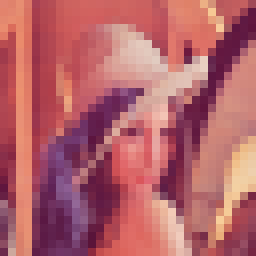

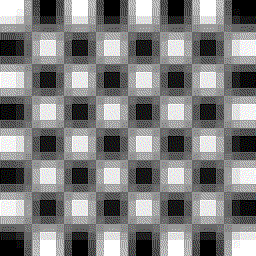

In [10]:
ca, training = build_configuration()
#training.ca_lifetime = 32
training.show_status(ca.imagefilled("checkers8.png"))